In [33]:
from matplotlib import pyplot as plt
import tfim_1d
from Ham_generator import *
from qcels import *
import qiskit
import concurrent.futures
import multiprocessing as mp
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import ParityMapper
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit_nature.second_q.circuit.library import HartreeFock
from qiskit_algorithms import NumPyMinimumEigensolver
from qiskit_nature.units import DistanceUnit
from qiskit_ibm_runtime import QiskitRuntimeService as QRS
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_aer.noise import NoiseModel, depolarizing_error, QuantumError, coherent_unitary_error, ReadoutError
from qiskit.circuit.library import Initialize
import matplotlib
matplotlib.rcParams['font.size'] = 15
matplotlib.rcParams['lines.markersize'] = 10
np.set_printoptions(threshold=np.inf)

In [2]:
# def compute_energy(distance, algorithm):
#     driver = PySCFDriver(
#         atom=f'H .0 .0 .0; H .0 .0 {distance}',
#         unit=DistanceUnit.ANGSTROM,
#         #charge=0,
#         #spin=0,
#         basis='sto3g'
#     )

#     molecule = driver.run()
#     mapper = ParityMapper(num_particles=molecule.num_particles)
#     hamiltonian = molecule.hamiltonian.second_q_op()
#     tapered_mapper = molecule.get_tapered_mapper(mapper)
#     operator = tapered_mapper.map(hamiltonian)
#     ham = operator.to_matrix()
#     if algorithm == 'NumPyMinimumEigensolver':
#         algo = NumPyMinimumEigensolver()
#         algo.filter_criterion = molecule.get_default_filter_criterion()
#         solver = GroundStateEigensolver(mapper, algo)
#         result = solver.solve(molecule)
#         gs_energy = result.total_energies[0]
#     else:
#         raise ValueError(f'Unrecognized algorithm: {algorithm}')
#     return result

In [3]:
# api_token = input("Enter API Token:")

In [4]:
# service = QRS(channel = 'ibm_quantum', instance='rpi-rensselaer/research/faulsf', token = api_token)
# rpi_backend = service.backend('ibm_rensselaer')
# noise_model = NoiseModel.from_backend(rpi_backend)


In [5]:
# print(noise_model)

In [6]:
# service = QRS(channel = 'ibm_quantum', instance='rpi-rensselaer/research/faulsf', token = api_token)
# rpi_backend = service.backend('ibm_rensselaer')

# for error_type in rpi_backend.target.operation_names:
#     for qubit in list(rpi_backend.target[error_type].keys()):
#         if qubit is None: continue
#         try: rpi_backend.target[error_type][qubit].error=0
#         except: continue

# noise_model = NoiseModel.from_backend(rpi_backend)
# print(noise_model)


In [34]:
num_sites = 2

#TFIM parameters
J_T = 1
g_T = 4

#HSM parameters
J_H = 4
g_H = 0

#Hubb parameters
t_H = 5
U_H = 12

#H2 molecule parameters
ang = 0.52917721092
distance = 0.5

Transverse Field Ising Model


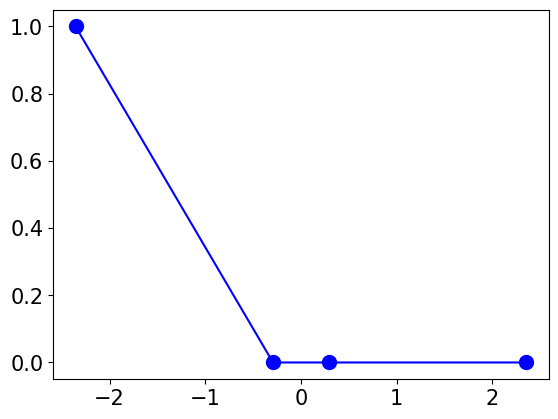

In [35]:
# T (TFIM), H (HSM), B (Hubbard), M (H2 molecule)
model_type = 'T'
# Q (Qiskit), F(F3C++)
Ham_type = 'Q'

if model_type[0].upper() == 'T':
    mn = 'TFIM'
    print('Transverse Field Ising Model')

    ham = create_hamiltonian(num_sites, 'TFIM', ham_shift, g = g_T, J=J_T, show_steps=False)
    eigenenergies, eigenstates = eigh(ham)
    ground_state = eigenstates[:,0]

    pop = np.abs(np.dot(eigenstates.conj().T, ground_state))**2

    plt.plot(eigenenergies, pop, 'b-o')
    plt.show()
    
if model_type[0].upper() == 'H':
    mn = 'HSM'

    print('Heisenberg Spin Model')

    ham = create_hamiltonian(num_sites, 'SPIN', ham_shift, g = g_H, J=J_H, show_steps=False)
    eigenenergies, eigenstates = eigh(ham)
    ground_state = eigenstates[:,0]

    pop = np.abs(np.dot(eigenstates.conj().T, ground_state))**2

    plt.plot(eigenenergies, pop, 'b-o')
    plt.show()

if model_type[0].upper() == 'B':
    mn = "HUBB"
    print('Hubbard Model')

    ham = create_hamiltonian(num_sites, 'HUBB', ham_shift, t = t_H, U=U_H, x = num_sites/2, y = num_sites/2, show_steps=False)

    eigenenergies, eigenstates = eigh(ham)
    ground_state = eigenstates[:,0]

    popp = np.abs(np.dot(eigenstates.conj().T, ground_state))**2

    plt.plot(eigenenergies, popp, 'b-o')
    plt.show()

if model_type[0].upper() == 'M':
    mn = 'HH'
    num_sites = 1
    print('H2 Molecule')

    driver = PySCFDriver(
        atom=f'H .0 .0 .0; H .0 .0 {distance}',
        unit=DistanceUnit.ANGSTROM,
        #charge=0,
        #spin=0,
        basis='sto3g'
    )
    #driver = PySCFDriver(atom='O 0.0 0.0 0.0; H 0.757 0.586 0.0; H -0.757 0.586 0.0', charge=0, spin=0, basis='sto3g')
    molecule = driver.run()
    mapper = ParityMapper(num_particles=molecule.num_particles)
    hamiltonian = molecule.hamiltonian.second_q_op()
    tapered_mapper = molecule.get_tapered_mapper(mapper)
    operator = tapered_mapper.map(hamiltonian)
    ham = operator.to_matrix()
    
    eigenenergies, eigenstates = eigh(ham)
    eigenenergies += ang/distance
    ground_state = eigenstates[:,0]

    popp = np.abs(np.dot(eigenstates.conj().T, ground_state))**2

    plt.plot(eigenenergies, popp, 'b-o')
    plt.show()

if Ham_type[0].upper() == 'F':
    unitaries, ground_state, eigenenergies = (generate_TFIM_gates(num_sites, 2, 1, g_T, ham_shift, '../../../f3cpp'))

In [36]:
print(eigenenergies[0])

-2.3561944901923453


In [49]:
# initialization: S (Quantum Simulation), or R (Quantum Hardware)

computation_type = 'R'
output_file = True
p0_array            = np.array([0.7, 0.8]) # initial overlap with the first eigenvector
deltas              = 1 - np.sqrt(p0_array)
trials              = 5 # number of comparisions each test (circuit depths)
tests               = 1
err_threshold       = 0.01
T0                  = 100

# QCELS variables
time_steps          = 5
#epsilons            = np.array([0.5, 0.1, 0.02, 0.009, 0.003, 0.001, 0.0005, 0.0002, 0.00009, 0.00004])
epsilons            = np.array([0.5, 0.02, 0.003, 0.0005, 0.00009])
#epsilons            = np.array([0.5, 0.02])
iterations          = [int(np.log2(1/i) + 1) for i in epsilons]
err_QCELS           = np.zeros((len(p0_array),trials))
est_QCELS           = np.zeros((len(p0_array),trials))
cost_list_avg_QCELS = np.zeros((len(p0_array),trials))
rate_success_QCELS  = np.zeros((len(p0_array),trials))
max_T_QCELS         = np.zeros((len(p0_array),trials))

In [50]:
# initialization: S (Quantum Simulation), or R (Quantum Hardware)

if computation_type[0].upper() == 'S':
    print("\nQUANTUM SIMULATION SELECTED\n")

    backend = AerSimulator()
    #backend = AerSimulator(noise_model=noise_model)
    # backend = AerSimulator(noise_model=noise_model,
    #                   coupling_map=coupling_map,
    #                   basis_gates=basis_gates)
    data_name = "Q_Sim"

if computation_type[0].upper() == 'R':
    print("\nQUANTUM HARDWARE SELECTED\n")    
    
    # save qiskit API token for later use
    api_token = input("Enter API Token:")
    service = QRS(channel = 'ibm_quantum', instance='rpi-rensselaer/research/faulsf', token = api_token)
    backend = service.backend('ibm_rensselaer')
    data_name = "Q_Real"

if output_file:
    outfile = open("Output/"+str(data_name)+"_"+str(mn)+"_trans.txt", 'w')



QUANTUM HARDWARE SELECTED



In [51]:
ansatz = []
for p in range(len(p0_array)):
    psi = ground_state

    # Generate a random vector orthogonal to psi
    random_vec = np.random.randn(2**num_sites) + 1j * np.random.randn(2**num_sites)
    random_vec -= np.vdot(psi, random_vec) * psi  # Make orthogonal to psi
    random_vec /= np.linalg.norm(random_vec)  # Normalize

    # Construct psi with the required squared overlap
    overlap_squared = p0_array[p]
    phi = np.sqrt(overlap_squared) * psi + np.sqrt(1 - overlap_squared) * random_vec

    print(np.abs(np.vdot(psi, phi))**2)
    ansatz.append(phi)

0.7000000000000002
0.8000000000000002


In [52]:
# Create HT for lambda_prior

lambda_results = []

if Ham_type[0].upper() == 'F':
    print('F3C++')
    for p in range(len(p0_array)):
        trans_qc2 = create_HT_circuit(num_sites, unitaries[1], W = 'Im', backend = backend, init_state=ansatz[p])
        trans_qc1 = create_HT_circuit(num_sites, unitaries[1], W = 'Re', backend = backend, init_state=ansatz[p])

        circs = [trans_qc1, trans_qc2]
        sampler = Sampler(backend)

        job = sampler.run(circs, shots = 1000)
        result = job.result()
        lambda_results.append(result)

if Ham_type[0].upper() == 'Q':
    print('Qiskit')
    for p in range(len(p0_array)):
        mat = expm(-1j*ham)
        controlled_U = UnitaryGate(mat).control(annotated="yes")

        trans_qc1 = create_HT_circuit(num_sites, controlled_U, W = 'Re', backend = backend, init_state = ansatz[p])
        trans_qc2 = create_HT_circuit(num_sites, controlled_U, W = 'Im', backend = backend, init_state = ansatz[p])

        circs = [trans_qc1, trans_qc2]
        sampler = Sampler(backend)

        job = sampler.run(circs, shots = 1000)
        result = job.result()
        lambda_results.append(result)

Qiskit


In [53]:
# Get lambda_prior
lambda_priors = []

for p in range(len(p0_array)):
    re_data = lambda_results[p][0].data
    im_data = lambda_results[p][1].data
    counts_re = re_data[list(re_data.keys())[0]].get_counts()
    counts_im = im_data[list(im_data.keys())[0]].get_counts()

    re_p0 = im_p0 = 0
    if counts_re.get('0') is not None:
        re_p0 = counts_re['0']/1000
    if counts_im.get('0') is not None:
        im_p0 = counts_im['0']/1000

    Re = 2*re_p0 - 1
    Im = 2*im_p0 - 1

    Angle = np.arccos(Re)
    if  np.arcsin(Im)<0:
        Phase = 2*np.pi - Angle
    else:
        Phase = Angle

    lambda_prior = -Phase
    lambda_priors.append(lambda_prior)

In [54]:
print(lambda_priors)

[-1.964920872345521, -2.0219454818226903]


In [55]:
# Parallel circuit transpilation

def transpile_qcels_trial(trial, p0, ansatz_p, epsilons, iterations, time_steps, num_sites, ham, backend):
    epsilon = epsilons[trial]
    T = 1 / epsilon

    for j in range(iterations[trial] + 1):
        tau = get_tau(j, time_steps, iterations[trial], T)
        qcs_QCELS = []

        for data_pair in range(time_steps):
            t = tau * data_pair
            mat = expm(-1j * ham * t)
            controlled_U = UnitaryGate(mat).control(annotated="yes")
            qcs_QCELS.append(create_HT_circuit(num_sites, controlled_U, W='Re', backend=backend, init_state=ansatz_p))
            qcs_QCELS.append(create_HT_circuit(num_sites, controlled_U, W='Im', backend=backend, init_state=ansatz_p))

        filename = f'Transpiled_Circuits/QCELS_p0={p0}_Trial{trial}_Iter={j}.qpy'
        with open(filename, 'wb') as f:
            qiskit.qpy.dump(qcs_QCELS, f)

    return trial  # for logging

In [56]:
# Transpiles circuits
if Ham_type[0].upper() == 'F':
    for p in range(len(p0_array)):
        p0=p0_array[p]
        n_success_QCELS= np.zeros(trials)
        n_success_QPE= np.zeros(trials)

        print("Testing p0 =", p0,"("+str(p+1)+"/"+str(len(p0_array))+")")

        if output_file: print("Testing p0 =", p0,"("+str(p+1)+"/"+str(len(p0_array))+")", file = outfile)

        print("  Generating QCELS circuits", "(p0="+str(p0)+")")

        #------------------QCELS-----------------
        for trial in range(trials):
            print("    Transpiling QCELS", "("+str(trial+1)+"/"+str(trials)+")")
            epsilon = epsilons[trial]

            if output_file: print("    Transpiling QCELS", "("+str(trial+1)+"/"+str(trials)+")", file = outfile, flush = True)
            T = 1/epsilon
            for j in range(iterations[trial] + 1):
                tau = get_tau(j, time_steps, iterations[trial], T)
                qcs_QCELS = []
                unitaries, _, _= (generate_TFIM_gates(num_sites, time_steps, tau, g_T, ham_shift, '../../../f3cpp'))
                for data_pair in range(time_steps):
                    qcs_QCELS.append(create_HT_circuit(num_sites, unitaries[data_pair], W = 'Re', backend = backend, init_state = ansatz[p]))
                    qcs_QCELS.append(create_HT_circuit(num_sites, unitaries[data_pair], W = 'Im', backend = backend, init_state = ansatz[p]))
                with open('Transpiled_Circuits/QCELS_p0='+str(p0)+'_Trial'+str(trial)+'_Iter='+str(j)+'.qpy', 'wb') as f:
                    qiskit.qpy.dump(qcs_QCELS, f)
        print('Finished transpiling for QCELS ', "(p0="+str(p0)+")")
        
if Ham_type[0].upper() == 'Q':
    # Main loop for parallel execution
    for p in range(len(p0_array)):
        p0 = p0_array[p]
        ansatz_p = ansatz[p]

        print(f"Testing p0 = {p0} ({p+1}/{len(p0_array)})")
        if output_file:
            print(f"Testing p0 = {p0} ({p+1}/{len(p0_array)})", file=outfile)

        if computation_type[0].upper() == 'R':
            print(f"  Generating QCELS circuits (p0={p0})")
            for trial in range(trials):
                trial_done = transpile_qcels_trial( trial, p0, ansatz_p,
                        epsilons, iterations, time_steps, num_sites, 
                        ham, backend)
                print(f"    Completed QCELS Trial {trial_done+1}/{trials}")
        
        if computation_type[0].upper() == 'S':
            max_workers = max(4, mp.cpu_count())
            with concurrent.futures.ProcessPoolExecutor(max_workers=max_workers) as executor:
                futures = [
                    executor.submit(
                        transpile_qcels_trial, trial, p0, ansatz_p,
                        epsilons, iterations, time_steps, num_sites, 
                        ham, backend
                    )
                    for trial in range(trials)
                ]
                for future in concurrent.futures.as_completed(futures):
                    trial_done = future.result()
                    print(f"    Completed QCELS Trial {trial_done+1}/{trials}")

        print(f'Finished transpiling for QCELS (p0={p0})')


Testing p0 = 0.7 (1/2)
  Generating QCELS circuits (p0=0.7)
    Completed QCELS Trial 1/5
    Completed QCELS Trial 2/5
    Completed QCELS Trial 3/5
    Completed QCELS Trial 4/5
    Completed QCELS Trial 5/5
Finished transpiling for QCELS (p0=0.7)
Testing p0 = 0.8 (2/2)
  Generating QCELS circuits (p0=0.8)
    Completed QCELS Trial 1/5
    Completed QCELS Trial 2/5
    Completed QCELS Trial 3/5
    Completed QCELS Trial 4/5
    Completed QCELS Trial 5/5
Finished transpiling for QCELS (p0=0.8)


In [57]:
# Loads transpiled circuits
QCELS_depths = []

qcs_QCELS = []

for p in range(len(p0_array)):
    p0 = p0_array[p]
    QCELS_depths.append([])
    for test in range(tests):
        QCELS_depths[p].append([])
        for trial in range(trials):
            depth = 0
            print('Loading QCELS data ('+str(trial+1)+'/'+str(trials)+')')
            for i in range(iterations[trial] + 1):
                with open('Transpiled_Circuits/QCELS_p0='+str(p0)+'_Trial'+str(trial)+'_Iter='+str(i)+'.qpy', 'rb') as f:
                    circs = qiskit.qpy.load(f)
                    for time_step in range(time_steps):
                        depth += circs[time_step].depth() 
                    qcs_QCELS.append(circs)

            QCELS_depths[p][test].append(depth)

qcs_QCELS = sum(qcs_QCELS, []) # flatten list


Loading QCELS data (1/5)
Loading QCELS data (2/5)
Loading QCELS data (3/5)
Loading QCELS data (4/5)
Loading QCELS data (5/5)
Loading QCELS data (1/5)
Loading QCELS data (2/5)
Loading QCELS data (3/5)
Loading QCELS data (4/5)
Loading QCELS data (5/5)


In [58]:
#num_splits = len(p0_array)*tests
num_splits = 1
split = int(len(qcs_QCELS)/num_splits)

qcs_QCELS_circuits = []
for i in range(num_splits):
    qcs_QCELS_circuits.append(qcs_QCELS[i*split:(i+1)*split])

In [59]:
# Runs loaded circuits
print('Running transpiled circuits')
sampler = Sampler(backend)
jobs = []
results = []
for i in range(num_splits):
    job = sampler.run(qcs_QCELS_circuits[i], shots = T0)
    result = job.result()
    jobs.append(job)
    results.append(result)

Running transpiled circuits


In [60]:
results = flatten(results)

In [61]:
Z_ests = []
QCELS_times = []

for p in range(len(p0_array)):
    Z_ests.append([])
    QCELS_times.append([])
    for test in range(tests):
        Z_ests[p].append([])
        QCELS_times[p].append([])
        for trial in range(trials):
            exec_time = 0
            Z_ests[p][test].append([])
            for iter in range(iterations[trial] + 1):
                Z_ests[p][test][trial].append([])
                for time_step in range(time_steps):
                    index = time_step*2 + iter*time_steps*2 + (sum(iterations[0:trial])+trial)*time_steps*2 + test*(sum(iterations)+len(iterations))*time_steps*2 + p*tests*(sum(iterations)+len(iterations))*time_steps*2
                    raw_data_re = results[index].data
                    counts_re = raw_data_re[list(raw_data_re.keys())[0]].get_counts()
                    raw_data_im = results[index + 1].data
                    counts_im = raw_data_im[list(raw_data_im.keys())[0]].get_counts()
                    exec_time += (0 + 1)

                    re_p0 = im_p0 = 0
                    if counts_re.get('0') is not None:
                        re_p0 = counts_re['0']/T0
                    if counts_im.get('0') is not None:
                        im_p0 = counts_im['0']/T0
                    
                    Re = 2*re_p0-1
                    Im = 2*im_p0-1 

                    Angle = np.arccos(Re)
                    if  np.arcsin(Im)<0:
                        Phase = 2*np.pi - Angle
                    else:
                        Phase = Angle
                    Phase = Phase
                    Z_est = complex(np.cos(Phase),np.sin(Phase))
                    Z_ests[p][test][trial][iter].append(Z_est)
            QCELS_times[p][test].append(exec_time)

In [62]:
if output_file:
    outfile = open("Output/"+str(data_name)+"_"+str(mn)+"_run.txt", 'w')

for p in range(len(p0_array)):
    p0=p0_array[p]
    lambda_prior = lambda_priors[p]
    
    n_success_QCELS= np.zeros(trials)
    n_success_QPE= np.zeros(trials)

    print("Testing p0 =", p0,"("+str(p+1)+"/"+str(len(p0_array))+")")

    if output_file: print("Testing p0 =", p0,"("+str(p+1)+"/"+str(len(p0_array))+")", file = outfile)

    for test in range(tests):

        print("  Generating QCELS and QPE data", "(p0="+str(p0)+")","("+str(test+1)+"/"+str(tests)+")")

        #spectrum, population = generate_spectrum_population(eigenenergies, population_raw, [p0])

        #------------------QCELS-----------------
        for trial in range(trials):
            print("    Running QCELS", "("+str(trial+1)+"/"+str(trials)+")")

            if output_file: print("    Running QCELS", "("+str(trial+1)+"/"+str(trials)+")", file = outfile, flush = True)
            epsilon = epsilons[trial]
            T = 1/epsilon
            #lambda_prior = spectrum[0]
            ground_energy_estimate_QCELS, cosT_depth_list_this = qcels_largeoverlap_new(Z_ests[p][test][trial], time_steps, lambda_prior, T)
            #ground_energy_estimate_QCELS, cosT_depth_list_this, max_T_QCELS_this = qcels_largeoverlap()
            
            #cosT_depth_list_this = QCELS_depths[p][test][trial]
            max_T_QCELS_this = 0

            if model_type[0].upper() == 'M':
                est_this_run_QCELS = ground_energy_estimate_QCELS.x[2] + ang/distance
            else:
                est_this_run_QCELS = ground_energy_estimate_QCELS.x[2] 

            #print("      Estimated ground state energy =", ground_energy_estimate_QCELS)
            if output_file: print("      Estimated ground state energy =", est_this_run_QCELS, file = outfile)
            
            err_this_run_QCELS = np.abs(est_this_run_QCELS - eigenenergies[0])
            err_QCELS[p,trial] = err_QCELS[p,trial]+np.abs(err_this_run_QCELS)
            est_QCELS[p,trial] = est_QCELS[p,trial] + est_this_run_QCELS
            cost_list_avg_QCELS[p,trial]=cost_list_avg_QCELS[p,trial]+cosT_depth_list_this
            max_T_QCELS[p,trial]=max(max_T_QCELS[p,trial],max_T_QCELS_this)

            if np.abs(err_this_run_QCELS)<err_threshold:
                n_success_QCELS[trial]+=1

        print("    Finished QCELS data\n")
        if output_file: print("    Finished QCELS data\n", file = outfile)

    rate_success_QCELS[p,:] = n_success_QCELS[:]/tests
    err_QCELS[p,:] = err_QCELS[p,:]/tests
    est_QCELS[p,:] = est_QCELS[p,:]/tests
    #cost_list_avg_QCELS[p,:]=cost_list_avg_QCELS[p,:]/tests
    cost_list_avg_QCELS[p,:]=2*cost_list_avg_QCELS[p,:]/tests # observables instead of time steps



Testing p0 = 0.7 (1/2)
  Generating QCELS and QPE data (p0=0.7) (1/1)
    Running QCELS (1/5)
      Preprocessing
      Starting Iteration (1/2)
      Starting Iteration (2/2)
      Finished Iterations
    Running QCELS (2/5)
      Preprocessing
      Starting Iteration (1/6)
      Starting Iteration (2/6)
      Starting Iteration (3/6)
      Starting Iteration (4/6)
      Starting Iteration (5/6)
      Starting Iteration (6/6)
      Finished Iterations
    Running QCELS (3/5)
      Preprocessing
      Starting Iteration (1/9)
      Starting Iteration (2/9)
      Starting Iteration (3/9)
      Starting Iteration (4/9)
      Starting Iteration (5/9)
      Starting Iteration (6/9)
      Starting Iteration (7/9)
      Starting Iteration (8/9)
      Starting Iteration (9/9)
      Finished Iterations
    Running QCELS (4/5)
      Preprocessing
      Starting Iteration (1/11)
      Starting Iteration (2/11)
      Starting Iteration (3/11)
      Starting Iteration (4/11)
      Starting Iterat

In [63]:
#model_type = 'M' HH molecule
if model_type[0].upper() == 'T':
    np.savez('Data/'+data_name+'_result_TFIM_'+str(num_sites)+'sites_QCELS',name1=rate_success_QCELS,name2=max_T_QCELS,name3=cost_list_avg_QCELS,name4=err_QCELS,name5=est_QCELS,name6=eigenenergies[0])
    #np.savez('Data/'+data_name+'_TFIM_8sites_data',name1=spectrum,name2=population,name3=ground_energy_estimate_QCELS.x[0],
            #name4=ground_energy_estimate_QCELS.x[1],name5=ground_energy_estimate_QCELS.x[2])
if model_type[0].upper() == 'H':
    np.savez('Data/'+data_name+'_result_HSM_'+str(num_sites)+'sites_QCELS',name1=rate_success_QCELS,name2=max_T_QCELS,name3=cost_list_avg_QCELS,name4=err_QCELS,name5=est_QCELS,name6=eigenenergies[0])
if model_type[0].upper() == 'B':
    np.savez('Data/'+data_name+'_result_HUBB_'+str(num_sites)+'sites_QCELS',name1=rate_success_QCELS,name2=max_T_QCELS,name3=cost_list_avg_QCELS,name4=err_QCELS,name5=est_QCELS,name6=eigenenergies[0])
if model_type[0].upper() == 'M':
    np.savez('Data/'+data_name+'_result_HH_'+str(num_sites)+'sites_QCELS',name1=rate_success_QCELS,name2=max_T_QCELS,name3=cost_list_avg_QCELS,name4=err_QCELS,name5=est_QCELS,name6=eigenenergies[0])

print("Saved data to files starting with", data_name)
if output_file: print("Saved data to files starting with", data_name, file = outfile, flush=True)
outfile.close()
if output_file: print("Saved output to file ", "Output/"+str(data_name)+".txt")


Saved data to files starting with Q_Real
Saved output to file  Output/Q_Real.txt
